#KERNEL SHAP

The goal of SHAP is to calculate the impact of every feature on the prediction.



How is Kernel SHAP different from other permutation importance methods -

In Kernel SHAP, instead of retraining models with permutations of features, we can use the full model that is already trained, and replace "missing features" with "samples from the data" that are estimated from a formula.
This means that we equate "absent feature value" with "feature value replaced by random feature value from data".

Now, this changed feature space is fitted to the linear model and the coefficients of this model act as Shapley values.

SHAP has the capability of both local and global interpretations. SHAP can compute the importance of each feature on the prediction for an individual instance and for the overall model as well.

SHAP values are consistent and reliable because if a model changes so that the marginal contribution(i.e. percentage out of the total) of a feature value increases or stays the same (regardless of other features), they increase or remain the same respectively.

Thus, SHAP values are mathematically more accurate.

In [1]:
!pip install alibi

     |████████████████████████████████| 225kB 2.8MB/s 
     |████████████████████████████████| 327kB 9.1MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 28.0MB 148kB/s 
     |████████████████████████████████| 204kB 51.9MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456467 sha256=478de1ce7b741705974e794b68f2ea8b5751f8e29842442dc11bf58fd6045762
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=3e64d2a108e789766bcb1c5447214ccb62a2ecefdfdbf17852d564ff7a445595
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data


In [4]:
import shap
shap.initjs()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from alibi.explainers import KernelShap
from scipy.special import logit
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


Loading and preparing data 

In [5]:
data = pd.read_csv('/content/heartu.csv')
# To display the top 5 rows
data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [6]:
heart = data.copy()

In [7]:
target = 'condition'
features_list = list(heart.columns)
features_list.remove(target)

In [8]:
y = heart.pop('condition')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(heart, y, test_size=0.2, random_state=33)

In [13]:
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

Training records: 237
Testing records: 60


In [14]:
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

Training data

In [15]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train_norm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
y_pred = classifier.predict(X_test_norm)

Checking for accuracy

Text(0.5, 1.0, 'Confusion matrix for the logistic regression classifier')

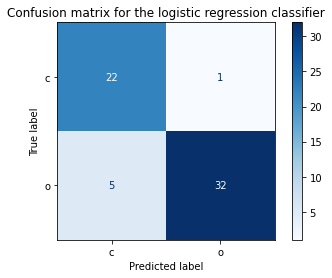

In [18]:
cm = confusion_matrix(y_test, y_pred)
title = 'Confusion matrix for the logistic regression classifier'
disp = plot_confusion_matrix(classifier,
                             X_test_norm,
                             y_test,
                             display_labels=target,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)

Applying Kernel SHAP

In [19]:
pred = classifier.predict_proba
lr_explainer = KernelShap(pred, link='logit') 
#The purpose of the logit link is to take a linear combination of the values (which may take any value between ±∞) and convert those values to the scale of a probability, i.e., between 0 and 1.
lr_explainer.fit(X_train_norm)

Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KernelShap(meta={
    'name': 'KernelShap',
    'type': ['blackbox'],
    'task': 'classification',
    'explanations': ['local', 'global'],
    'params': {
        'link': 'logit',
        'group_names': None,
        'grouped': False,
        'groups': None,
        'weights': None,
        'summarise_background': False,
        'summarise_result': None,
        'transpose': False,
        'kwargs': {}
    }
})

In [20]:
lr_explanation = lr_explainer.explain(X_test_norm, l1_reg=False)

LOCAL EXPLANATION -

In [43]:
idx =  4
instance = X_test_norm[idx][None, :]
pred = classifier.predict(instance)
class_idx = pred.item()
print("The predicted class for the X_test_norm[{}] is {}.".format(idx, *pred))

The predicted class for the X_test_norm[4] is 1.


In [44]:
shap.initjs()
shap.force_plot(lr_explanation.expected_value[class_idx], lr_explanation.shap_values[class_idx][idx,:], X_test_norm[idx][None, :],features_list)

The base value is the average of all output values of the model on the training data(here : -0.3148).

Pink values drag/push the prediction towards 1(pushes the prediction higher i.e. towards having heart disease) and the blue towards 0(pushes the predicion lower i.e. towards no disease).

The magnitude of influence is determined by the length of the features on the horizontal line. The value shown corresponding to the feature are the values of feature at the particular index(eg. 2.583 for ca). Here, the highest influence is of ca for increasing the prediction value and of sex for decreasing the value.

GLOBAL EXPLANATION -

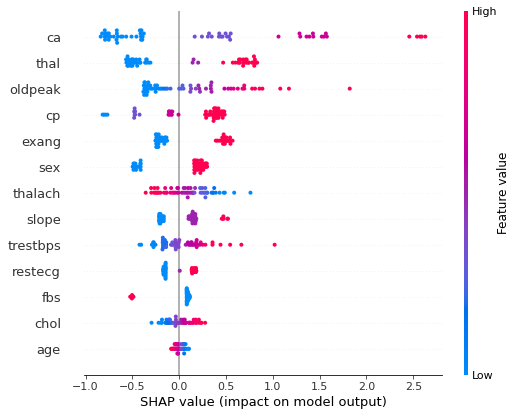

In [32]:
shap.summary_plot(lr_explanation.shap_values[1], X_test_norm, features_list)

The above plot visualizes the impact of features on the prediction class 1. The features are arranged such that the highest influence is of the topmost feature. Thus, ca is the feature that influences the prediction the most followed by thal and so on. 

The colour shades show the direction in which the feature impacts the prediction. For example, higher shap values of ca are shown in red colour which means high feature value. The higher the value of ca, the higher is the SHAP value i.e. more towards 1 . High ca ---> Heart Disease.


Almost all features show this pattern. However, it is the opposite for some features: High thalach will indicate less chances of Heart disease.